In [11]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm
import matplotlib.patheffects # for adding borders around text

import textwrap
import seaborn
import squarify

#import ttf_opensans

In [12]:
# set open sans as default font
mp.rcParams['font.family'] = 'Open Sans'

# gemplot variables

In [13]:
footer_color = "#222222"
footer_lineheight = 1.2
footer_fontsize = 14

# default height of a figure is 450 pixels

# gemstyle does this:
# specify a base_ratio, then set base_size = base_ratio*16
# 1. add 6 line margin all the way around
# 2. color of title is "#222222", margin 6666, size=base_size*1.5, lineheight=1.35, bold font
# 3. color of subtitle is "#333333", margin 0666, padding top=12, bottom=12, size=base_size*1.15, lineheight=1.45
# 4. set caption info as linehight=1.2, size=base_size*0.875, color="#222222", margin=18,6,6,6

base_ratio = 1.0
base_size = base_ratio * 16
color_title = "#222222"
color_subtitle = "#333333"
color_grid = "#cbcbcb"

text_weight_normal = 400
text_weight_bold = 700

# save fig
#' @keywords save_gem_plot
#' @examples
#' save_gem_plot(
#' plot_grid = line_plot_with_gem_footer,
#' save_filepath = "filename_that_my_plot_should_be_saved_to-nc.png",
#' width_pixels = 770,
#' height_pixels = 540,
#' resolution = 4
#' )
#'
#' @export
# save plot function - now separated from finalise_plot function and setting the resolution as part of the arguments
# save_gem_plot <- function (plot_grid, save_filepath, width_pixels = 640, height_pixels = 450, resolution = 3) {
#   grid::grid.draw(plot_grid)

#   #save it
#   ggplot2::ggsave(plot=plot_grid,
#                   width= (width_pixels/72),
#                   height= (height_pixels/72),
#                   dpi = resolution * 100,
#                   filename = save_filepath,
#                   bg="white")
# }

#width_pixels = 640 # default
#height_pixels = 450 # default

## define colors used in bars

In [14]:
# sel_cmap = matplotlib.colormaps['Reds']
# tracker_operating = sel_cmap(0.999)
# tracker_construction = sel_cmap(0.8)
# tracker_proposed = sel_cmap(0.6)
# tracker_shelved = sel_cmap(0.4)
# tracker_cancelled = sel_cmap(0.2)

tracker_construction = '#761200'
tracker_proposed = '#bf532c'
tracker_shelved = '#e3710c'
#tracker_cancelled = '#357a5d'
#tracker_cancelled = '#4e8a71'
tracker_cancelled = '#9abcae'

# import data directly from google sheets

In [15]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
#spreadsheet = gc.open_by_key('1WaBMIdfRWqSqXUw7_cKXo3RipyhPdnNN8flqEYfMZIA') # dec 2023 data release
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek') # CURRENT sheet

gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

pipes_df_orig = pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [16]:
status_list = ['proposed', 
               'construction', 
               'shelved', 
               'cancelled', 
               'operating', 
               'idle', 
               'mothballed', 
               'retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

#country_list = sorted(list(set(terms_df_orig['Country'])))
#region_list = sorted(list(set(terms_df_orig['Region'])))

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [17]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

missing_wiki_projectids = pipes_df_orig.loc[pipes_df_orig.Wiki==''].ProjectID.tolist()
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']

country_ratios_df.replace('--', numpy.nan, inplace=True)
country_ratios_df = country_ratios_df.loc[~country_ratios_df.ProjectID.isin(missing_wiki_projectids)]

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_59387/1850051164.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_59387/1850051164.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_ratios_df.replace('--', numpy.nan, inplace=True)


# km by country, km by region calculations

In [18]:
dict_subregion_region = pandas.Series(region_df_orig.Region.values, index=region_df_orig.SubRegion).to_dict()
dict_subregion_region

{'Latin America and the Caribbean': 'Americas',
 '--': '--',
 'Australia and New Zealand': 'Oceania',
 'Central Asia': 'Asia',
 'Eastern Asia': 'Asia',
 'Eastern Europe': 'Europe',
 'Melanesia': 'Oceania',
 'Micronesia': 'Oceania',
 'Northern Africa': 'Africa',
 'Northern America': 'Americas',
 'Northern Europe': 'Europe',
 'Polynesia': 'Oceania',
 'South-eastern Asia': 'Asia',
 'Southern Asia': 'Asia',
 'Southern Europe': 'Europe',
 'Sub-Saharan Africa': 'Africa',
 'Western Asia': 'Asia',
 'Western Europe': 'Europe'}

In [19]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [22]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    km_by_country_df[status] = country_ratios_fuel_df_status.groupby('Country')['LengthMergedKmByCountry'].sum()
    km_by_subregion_df[status] = country_ratios_fuel_df_status.groupby(['Region','SubRegion'])['LengthMergedKmByCountry'].sum()
    km_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['LengthMergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_subregion_df = km_by_subregion_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)
km_by_region_df = km_by_region_df.fillna(0)

#km_by_region_df.sort_index(level='Region', inplace=True)
#km_by_region_df = km_by_region_df.loc[~(km_by_region_df==0).all(axis=1)]

# total
# km_by_region_df.loc['Total',:] = km_by_region_df.sum(axis=0).values
# km_by_country_df.loc['Total',:] = km_by_country_df.sum(axis=0).values

km_by_subregion_df['proposed+construction'] = km_by_subregion_df[['proposed','construction']].sum(axis=1)
km_by_subregion_df = km_by_subregion_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]

km_by_country_df['proposed+construction'] = km_by_country_df[['proposed','construction']].sum(axis=1)
km_by_country_df.sort_values('proposed+construction', ascending=False, inplace=True)
km_by_country_df = km_by_country_df.loc[~(km_by_country_df==0).all(axis=1)]
km_by_country_df.loc[:,'Region'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].Region
km_by_country_df.loc[:,'Subregion'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].SubRegion
km_by_country_df = km_by_country_df[['Region','Subregion','proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
km_by_country_df = km_by_country_df.loc[(km_by_country_df.Region!='--')&
                                        (km_by_country_df.Subregion!='--')]

km_by_region_df['proposed+construction'] = km_by_region_df[['proposed','construction']].sum(axis=1)
km_by_region_df = km_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]

km_by_subregion_df.index.set_names(['Region','Subregion'], inplace=True)
km_by_subregion_df.loc['Total',:] = km_by_subregion_df.sum(axis=0).values
km_by_subregion_df.replace(0,'', inplace=False)

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


proposed construction  \
Region   Subregion                                                 
Africa   Northern Africa                     6139.5      1121.55   
         Sub-Saharan Africa                 19388.3       1582.0   
Americas Latin America and the Caribbean   15555.28       3008.0   
         Northern America                   7980.47      3224.26   
Asia     Central Asia                       4554.54       813.77   
         Eastern Asia                      42160.83     27973.35   
         South-eastern Asia                 8849.03        666.0   
         Southern Asia                     10651.84     23337.86   
         Western Asia                       4483.75      9772.55   
Europe   Eastern Europe                    22157.16      5053.19   
         Northern Europe                     972.49          1.2   
         Southern Europe                    6765.84        986.0   
         Western Europe                      905.55         98.0   
Oceania  Australia and New Zealand          9856.64          4.3   
         Melanesia                            320.0                
         Micronesia                                                
         Polynesia                                                 
Total                                     160741.22     77642.03   

                                         proposed+construction   shelved  \
Region   Subregion                                                         
Africa   Northern Africa                               7261.05    412.39   
         Sub-Saharan Africa                            20970.3   1274.72   
Americas Latin America and the Caribbean              18563.28   4734.05   
         Northern America                             11204.73   3818.47   
Asia     Central Asia                                  5368.31    966.33   
         Eastern Asia                                 70134.18   7285.12   
         South-eastern Asia                            9515.03   2562.41   
         Southern Asia                                 33989.7    2199.0   
         Western Asia                                  14256.3   2760.69   
Europe   Eastern Europe                               27210.35   2450.92   
         Northern Europe                                973.69    1000.0   
         Southern Europe                               7751.84     834.0   
         Western Europe                                1003.55             
Oceania  Australia and New Zealand                     9860.94   3726.22   
         Melanesia                                       320.0     400.0   
         Micronesia                                                        
         Polynesia                                                         
Total                                                238383.25  34424.32   

                                         cancelled   operating     idle  \
Region   Subregion                                                        
Africa   Northern Africa                     275.0    42476.47            
         Sub-Saharan Africa                 176.96     7141.52            
Americas Latin America and the Caribbean   3589.66    61912.79    331.0   
         Northern America                 20654.99   400989.45   110.63   
Asia     Central Asia                      1990.59    32487.69            
         Eastern Asia                      4424.02    144942.7            
         South-eastern Asia                 1479.0    17603.13            
         Southern Asia                    12202.97    40327.49            
         Western Asia                      9003.75    37570.31            
Europe   Eastern Europe                    9887.87   145167.38  1651.65   
         Northern Europe                   1003.77    25671.97            
         Southern Europe                   4436.09    28487.21            
         Western Europe                     2138.2    28615.96     8.35   
Oceania  Australia and New Zealand  

In [23]:
km_by_country_df.to_excel('km-by-country-region-subregion.xlsx')
km_by_country_df

,Region,Subregion,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
China,Asia,Eastern Asia,40740.84,27951.55,68692.39,6232.16,3059.51,139358.42,0.00,127.53,114.40
Russia,Europe,Eastern Europe,17404.71,4169.63,21574.34,1194.05,6316.52,115339.70,414.27,1411.91,2263.58
India,Asia,Southern Asia,5358.12,14445.61,19803.73,1310.00,6211.05,18914.16,0.00,0.00,0.00
Australia,Oceania,Australia and New Zealand,9856.64,4.30,9860.94,3726.22,7214.68,29524.34,0.00,0.00,0.00
United States,Americas,Northern America,7406.06,1396.42,8802.48,3736.66,14090.73,339176.03,110.63,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
Liechtenstein,Europe,Western Europe,0.00,0.00,0.00,0.00,1.90,1.29,0.00,0.00,0.00
Bolivia,Americas,Latin America and the Caribbean,0.00,0.00,0.00,825.02,0.00,2525.46,0.00,0.00,0.00
Brunei,Asia,South-eastern Asia,0.00,0.00,0.00,0.00,0.00,39.00,0.00,0.00,0.00
"Joint regime area (Peru, Ecuador)",Americas,Latin America and the Caribbean,0.00,0.00,0.00,0.00,0.00,13.28,0.00,0.00,0.00


In [24]:
km_by_country_df.sort_values('construction', ascending=False).to_excel('km-by-country-region-subregion-sorted-by-construction.xlsx')
#km_by_country_df

In [25]:
km_by_region_df

,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
Africa,25527.80,2703.55,28231.35,1687.11,451.96,49617.99,0.00,1332.76,0.00
Americas,23535.75,6232.26,29768.01,8552.52,24244.65,462902.24,441.63,224.00,0.00
Asia,70699.99,62563.53,133263.52,15773.55,29100.33,272931.32,0.00,1503.31,229.68
Europe,30801.04,6138.39,36939.43,4284.92,17465.93,227942.52,1660.00,4997.55,3445.27
Oceania,10176.64,4.30,10180.94,4126.22,7515.50,32754.34,0.00,0.00,0.00


## figure for km by subregion (marimekko/mosaic type)

In [26]:
treemap_colors = {'Americas':'#c75a00',
                  'Asia':'#580000',
                  'Europe':'#902c00',
                  'Africa':'#f98c28',
                  'Oceania':'#ffd370'}

In [27]:
km_by_subregion_df

proposed  construction  \
Region   Subregion                                                  
Africa   Northern Africa                    6139.50       1121.55   
         Sub-Saharan Africa                19388.30       1582.00   
Americas Latin America and the Caribbean   15555.28       3008.00   
         Northern America                   7980.47       3224.26   
Asia     Central Asia                       4554.54        813.77   
         Eastern Asia                      42160.83      27973.35   
         South-eastern Asia                 8849.03        666.00   
         Southern Asia                     10651.84      23337.86   
         Western Asia                       4483.75       9772.55   
Europe   Eastern Europe                    22157.16       5053.19   
         Northern Europe                     972.49          1.20   
         Southern Europe                    6765.84        986.00   
         Western Europe                      905.55         98.00   
Oceania  Australia and New Zealand          9856.64          4.30   
         Melanesia                           320.00          0.00   
         Micronesia                            0.00          0.00   
         Polynesia                             0.00          0.00   
Total                                     160741.22      77642.03   

                                          proposed+construction   shelved  \
Region   Subregion                                                          
Africa   Northern Africa                                7261.05    412.39   
         Sub-Saharan Africa                            20970.30   1274.72   
Americas Latin America and the Caribbean               18563.28   4734.05   
         Northern America                              11204.73   3818.47   
Asia     Central Asia                                   5368.31    966.33   
         Eastern Asia                                  70134.18   7285.12   
         South-eastern Asia                             9515.03   2562.41   
         Southern Asia                                 33989.70   2199.00   
         Western Asia                                  14256.30   2760.69   
Europe   Eastern Europe                                27210.35   2450.92   
         Northern Europe                                 973.69   1000.00   
         Southern Europe                                7751.84    834.00   
         Western Europe                                 1003.55      0.00   
Oceania  Australia and New Zealand                      9860.94   3726.22   
         Melanesia                                       320.00    400.00   
         Micronesia                                        0.00      0.00   
         Polynesia                                         0.00      0.00   
Total                                                 238383.25  34424.32   

                                          cancelled   operating     idle  \
Region   Subregion                                                         
Africa   Northern Africa                     275.00    42476.47     0.00   
         Sub-Saharan Africa                  176.96     7141.52     0.00   
Americas Latin America and the Caribbean    3589.66    61912.79   331.00   
         Northern America                  20654.99   400989.45   110.63   
Asia     Central Asia                       1990.59    32487.69     0.00   
         Eastern Asia                       4424.02   144942.70     0.00   
         South-eastern Asia                 1479.00    17603.13     0.00   
         Southern Asia                     12202.97    40327.49     0.00   
         Western Asia                       9003.75    37570.31     0.00   
Europe   Eastern Europe                     9887.87   145167.38  1651.65   
         Northern Europe                    1003.77    25671.97     0.00   
         Southern Europe                    4436.09    28487.21     0.00   
         Western Europe                     2138.20    28

In [28]:
# build bar thicknesses, normalized by total and by regional subtotals
km_by_subregion_df_toplot = km_by_subregion_df.drop('Total')

regional_sum_df = km_by_subregion_df_toplot.groupby(level='Region').sum()
region_order = regional_sum_df.sort_values(by='proposed+construction', ascending=False).index.values
regional_sum_df = regional_sum_df.reindex(index=region_order)

# sort first by construction values, THEN reorder based on region_order
km_by_subregion_df_toplot = km_by_subregion_df_toplot.sort_values(
    ['Region','construction'], ascending=False).reindex(
    level=0, index=region_order)

# before normalizing stuff, get km thickness
bar_thickness_km_df = km_by_subregion_df_toplot[['proposed+construction']]
regional_sum_df_normalized = regional_sum_df/regional_sum_df.sum(axis=0)

# normalize km_by_subregion so that each region adds up to 1.0
km_by_subregion_df_toplot_normalized = km_by_subregion_df_toplot/regional_sum_df
# then multiply by region_sum_df_normalized so ALL regions add up to a total of 1.0
# this will be what you need to plot for a normalized y-axis marimekko
km_by_subregion_df_toplot_normalized = (km_by_subregion_df_toplot_normalized*regional_sum_df_normalized).replace(numpy.nan,0)

bar_thickness_df = km_by_subregion_df_toplot_normalized[['proposed+construction']]
# we only care about what's under construction or proposed, so normalize the first two columns by proposed+construction
bar_fractional_width_df = km_by_subregion_df_toplot_normalized[['proposed','construction']].div(
    km_by_subregion_df_toplot_normalized[['proposed','construction']].sum(axis=1), axis=0).replace(numpy.nan,0) 

# # remove all-zero rows
bar_thickness_df = bar_thickness_df.loc[(bar_thickness_df!=0).any(axis=1)]
bar_thickness_km_df = bar_thickness_km_df.loc[(bar_thickness_km_df!=0).any(axis=1)]
bar_fractional_width_df = bar_fractional_width_df.loc[(bar_fractional_width_df!=0).any(axis=1)]
bar_percentage_width_df = bar_fractional_width_df*100.

# add a colors column to bar_thickness_df
bar_thickness_df['Colors'] = ''
bar_thickness_km_df['Colors'] = ''
for idx,row in bar_thickness_df.iterrows():
    bar_thickness_df.loc[idx,'Colors'] = treemap_colors[idx[0]]
    bar_thickness_km_df.loc[idx,'Colors'] = treemap_colors[idx[0]]

km_by_subregion_df_toplot['Colors'] = ''
for idx,row in km_by_subregion_df_toplot.iterrows():
    km_by_subregion_df_toplot.loc[idx,'Colors'] = treemap_colors[idx[0]]

In [29]:
km_by_region_df['proposed+construction'].sum()

np.float64(238383.25)

## figure 1 - marimekko

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_59387/169426839.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=base_size,


Text(-0.17216589861751153, -0.1323529411764706, 'Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines')

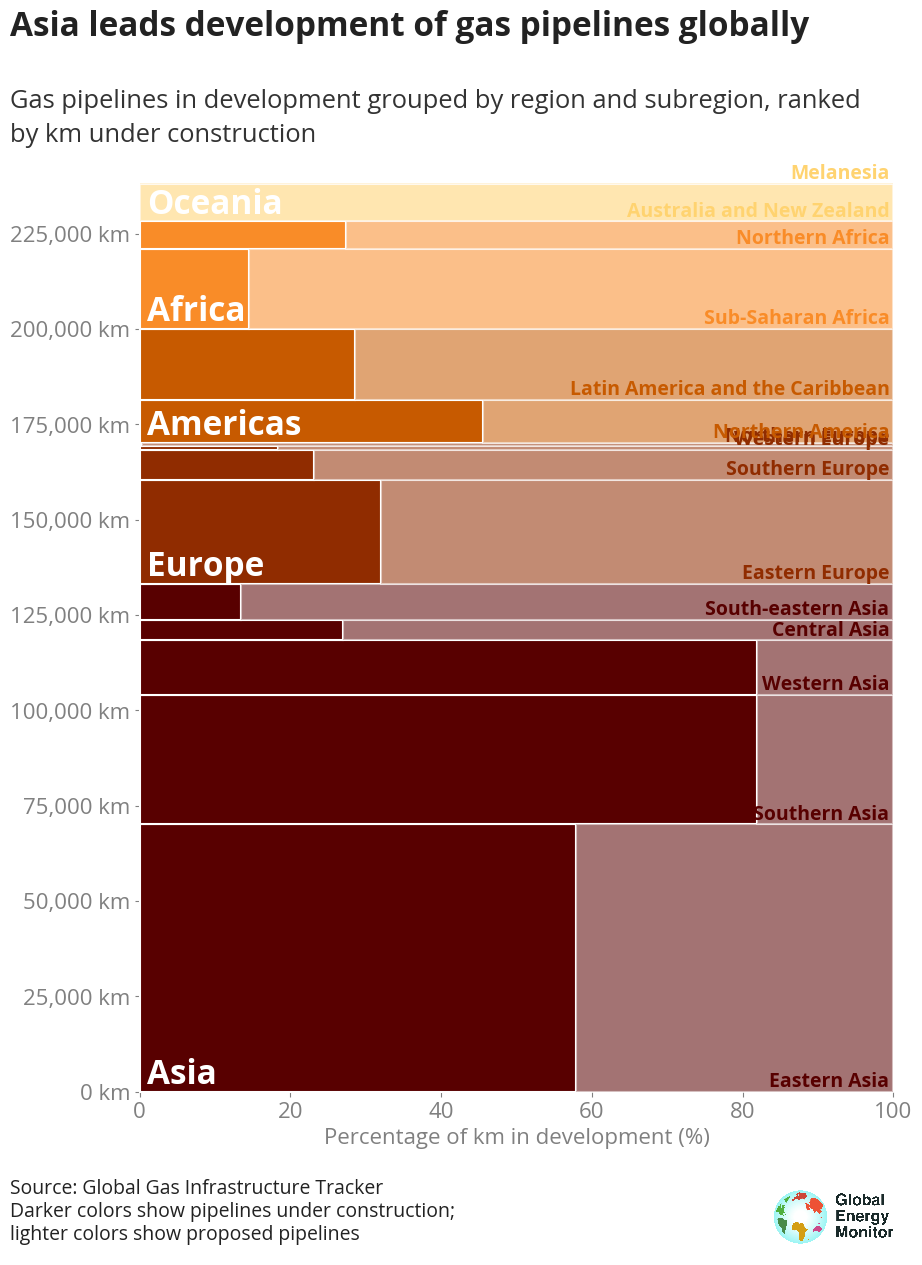

In [30]:
width_pixels = 700 # 640 default
height_pixels = 850 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

nbars = bar_thickness_df.shape[0]
bar_km_cumsum = bar_thickness_km_df['proposed+construction'].cumsum().values
bar_lower_edges = numpy.append(numpy.array(0), bar_km_cumsum[:-1])
bar_center_points = (numpy.append(numpy.array(0), bar_km_cumsum)[1:] - numpy.append(numpy.array(0), bar_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), bar_km_cumsum[:-1])

region_km_cumsum = regional_sum_df['proposed+construction'].cumsum().values
region_lower_edges = numpy.append(numpy.array(0), region_km_cumsum[:-1])
region_center_points = (numpy.append(numpy.array(0), region_km_cumsum)[1:] - numpy.append(numpy.array(0), region_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), region_km_cumsum[:-1])

ax = fig.add_subplot(111)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.construction,
        height=bar_thickness_km_df['proposed+construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        left=0,
        clip_on=False)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.proposed,
        height=bar_thickness_km_df['proposed+construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        alpha=0.55,
        left=bar_percentage_width_df.construction,
        clip_on=False)

for i in range(nbars):
    ax.text(s=bar_thickness_km_df.index.get_level_values('Subregion').tolist()[i],
            x=99.5,
            y=bar_lower_edges[i]+0.01,
            ha='right',
            va='bottom',
            color=bar_thickness_km_df['Colors'].tolist()[i],
            size=base_size*0.875,
            weight=text_weight_bold)

for i in range(region_list.__len__()):
    ax.text(s=region_order[i],
            x=1,
            y=region_lower_edges[i]+0.005,#region_center_points[i],
            ha='left',
            va='bottom',
            size=base_size*1.5,
            color='1',
            weight=text_weight_bold)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(labelsize=base_size,
               color=axis_text_color,
               labelcolor=axis_text_color,)

# format axis to have proper units and commas in thousands place
ax.yaxis.set_ticks(numpy.arange(0,ax.get_ylim()[1],25000))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_ylim(0,bar_thickness_km_df.sum().values[0])
ax.set_xlim(0,100.)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2

ax.set_axisbelow(True)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Gas pipelines in development grouped by region and subregion, ranked\nby km under construction',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=False)

bbox_with_subtitle = ax.get_tightbbox()
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Asia leads development of gas pipelines globally',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.set_xlabel('Percentage of km in development (%)',
              size=base_size, color=axis_text_color)

# LEGEND AND GEM LOGO
ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.5), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.25*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

# ax.tick_params(labelsize=font_size)
# ax.set_ylabel('km of pipelines in development', size=font_size)
# ax.set_xlabel('Fraction of pipelines under construction (left)\nand proposed (right)', size=font_size)

# projects by country, by region

In [31]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_country_df[status] = country_ratios_fuel_df_status.groupby('ProjectID')['MergedKmByCountry'].count()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['MergedKmByCountry'].count()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
proposed


KeyError: 'Column not found: MergedKmByCountry'

In [32]:
num_by_region_df

,proposed,construction,shelved,cancelled,operating,idle,mothballed,retired
Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Americas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oceania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## percent pipelines with start date (sanity check)

In [33]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['proposed','construction','shelved']))]

In [34]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


np.float64(0.4824380165289256)

## regional pipelines started in given year

In [35]:
pipes_df_orig['StartYearEarliest'].min()

TypeError: '<=' not supported between instances of 'int' and 'str'

In [ ]:
years_array = numpy.arange(float(pipes_df_orig['StartYearEarliest'].min()), 
                           float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [ ]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['operating'])) & pipes_df['Fuel']=='oil']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['operating','retired','idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

## figure 2 - top 15 countries proposed+construction

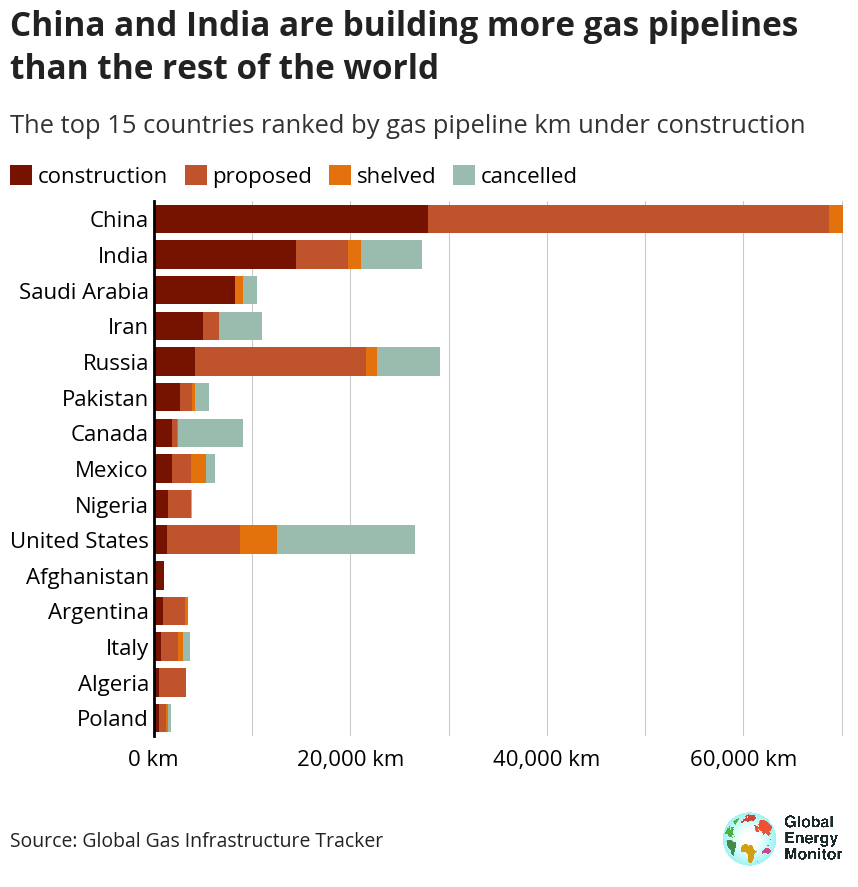

In [36]:
width_pixels = 640
height_pixels = 500
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
nbars=15

country_order = km_by_country_df.sort_values('construction', ascending=False).index[:nbars][::-1]

ax = fig.add_subplot(111)

bar_height = 0.8

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='construction',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['proposed'].values, 
        left=km_by_country_df.loc[country_order]['construction'].values, 
        facecolor=tracker_proposed,
        label='proposed',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['shelved'].values, 
        left=km_by_country_df.loc[country_order][['proposed','construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,
        label='shelved',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['cancelled'].values, 
        left=km_by_country_df.loc[country_order][['proposed','construction','shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,
        label='cancelled',
        height=bar_height)

# FORMATTING
ax.tick_params(labelsize=base_size)
ax.tick_params(which='both',size=0)
ax.tick_params('x', pad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(2)

# format axis to have proper units and commas in thousands place
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_xlim(0,70100)
ax.set_ylim(-.5,nbars-.5)
ax.set_xticks([0,20000,40000,60000])

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2
ax.xaxis.grid(which='both',
              color=color_grid)

ax.set_axisbelow(True)
ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(country_order)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_locatio"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,_ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])
legend = ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

# now get tight bbox again for further placement AFTER legend is added
bbox = legend.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='The top 15 countries ranked by gas pipeline km under construction',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=True)

bbox_with_subtitle = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='China and India are building more gas pipelines\nthan the rest of the world',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.text(s='Source: Global Gas Infrastructure Tracker',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.22*450/height_pixels, # make sure the caption adjust appropriately relative to default height of 450
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.15), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# mp.savefig('../figures/Figure02-gas-pipelines_top-20-countries-sorted-by-construction.png',
#           bbox_inches='tight',
#           transparent=False,
#           dpi=300)

# mp.savefig('../figures/Figure02-gas-pipelines_top-20-countries-sorted-by-construction.pdf',
#           bbox_inches='tight', 
#           transparent=False)

In [37]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['proposed+construction']/km_by_country_df.loc['India']['proposed+construction']

np.float64(3.468659186930947)

# parent analysis

In [39]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Gas')&(country_ratios_df.Status.isin(['proposed','construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    if parent_string == '--':
        parent_string = 'Unknown [unknown %]'
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

NameError: name 'parents_df' is not defined

## print out leading parent companies

In [40]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['proposed','construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'proposed','construction','In Development (proposed + construction)','ProjectIDs'])

parent_country_km_df_table['proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

AttributeError: 'DataFrame' object has no attribute 'Status'

In [41]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (proposed + construction)'] = parent_country_km_df_table[['proposed','construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (proposed + construction)', ascending=False)[:20]

KeyError: 'Parent'

### count fraction of available capacity information

count

In [42]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['construction','proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
Africa        9
Americas    113
Asia        286
Europe      107
Oceania      17
Name: CapacityBOEd, dtype: int64

fraction

In [43]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
Americas,0.843
Oceania,0.654
Asia,0.629
Europe,0.512
Africa,0.237


In [44]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()

In [45]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()).median()

In [46]:
pipes_df_orig['CapacityBcm/y'].mean()

np.float64(8.084632107023412)

In [47]:
pipes_df_orig['CapacityBcm/y'].std()

np.float64(12.45538239463203)

In [48]:
print(median_capacity)
print(abs_dist_from_med_capacity)

3.455
2.975


median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

## pick out high and low quantiles

In [49]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel=='Gas')]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

144626.191345
18122488.0395


In [50]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas') & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

In [51]:
country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas') & 
                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                    (country_ratios_df['LengthKnownKmByCountry'].notna())].shape

(826, 36)

In [52]:
country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas')].shape

(4296, 36)

In [53]:
1034/4012

0.2577268195413759

### global mean value

In [54]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

np.float64(2072756.5760422535)

### calculate regional costs

In [55]:
region_list

['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

In [56]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_59387/3912453063.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1167369.3344444446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()


In [57]:
pipes_costs_subregion_df = pandas.DataFrame(0, index=subregion_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for subregion in subregion_list:
    country_ratios_subregion_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['SubRegion']==subregion,:]
    pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()
    pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()

# for subregions with no data, inherit from the REGIONAL cost
for idx,row in pipes_costs_subregion_df.loc[pipes_costs_subregion_df.CostUSDPerKm.isnull()].iterrows():
    #print(pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'])
    which_region = idx
    pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'] = pipes_costs_region_df.loc[dict_subregion_region[which_region],'CostUSDPerKm']

pipes_costs_subregion_df.sort_values('CostUSDPerKm', ascending=False)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_59387/3870605072.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2780816.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()


,CostUSDPerKm,DataPoints
Northern America,"4,580,464.104",100
Western Asia,"4,269,833.553",30
Latin America and the Caribbean,"3,268,128.318",30
Southern Europe,"3,079,966.102",24
Western Europe,"3,042,619.264",5
South-eastern Asia,"3,003,802.880",2
Melanesia,"2,780,816.625",0
Micronesia,"2,780,816.625",0
Polynesia,"2,780,816.625",0
Australia and New Zealand,"2,780,816.625",4


In [58]:
pipes_costs_region_df

,CostUSDPerKm,DataPoints
Africa,"1,167,369.334",16
Americas,"4,249,949.906",129
Asia,"1,624,985.223",537
Europe,"2,341,037.039",59
Oceania,"2,780,816.625",4


In [59]:
country_ratios_region_df['CostUSDPerKm'].mean()

np.float64(2780816.625)

In [60]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Americas,4.250,129
Oceania,2.781,4
Europe,2.341,59
Asia,1.625,537
Africa,1.167,16


In [61]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_subregion_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Northern America,4.580,100
Western Asia,4.270,30
Latin America and the Caribbean,3.268,30
Southern Europe,3.080,24
Western Europe,3.043,5
South-eastern Asia,3.004,2
Melanesia,2.781,0
Micronesia,2.781,0
Polynesia,2.781,0
Australia and New Zealand,2.781,4


# tables etc.

## table for stranded asset calculations

## country-level capex estimates

In [62]:
pipes_costs_region_df.sort_values('CostUSDPerKm', ascending=False)

,CostUSDPerKm,DataPoints
Americas,"4,249,949.906",129
Oceania,"2,780,816.625",4
Europe,"2,341,037.039",59
Asia,"1,624,985.223",537
Africa,"1,167,369.334",16


add a cost USD estimate column and estimate costs based on region and km by country

In [63]:
pipes_costs_subregion_df

,CostUSDPerKm,DataPoints
Australia and New Zealand,"2,780,816.625",4
Central Asia,"1,415,177.033",20
Eastern Asia,"1,425,159.698",481
Eastern Europe,"1,526,922.550",28
Latin America and the Caribbean,"3,268,128.318",30
Melanesia,"2,780,816.625",0
Micronesia,"2,780,816.625",0
Northern Africa,"1,084,123.835",15
Northern America,"4,580,464.104",100
Northern Europe,"2,212,682.208",4


In [64]:
country_ratios_df.reset_index(drop=True, inplace=True)
country_ratios_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_df.iterrows():
    # calculate cost
    cntry = row.Country
    #region = row.Region
    subregion = row.SubRegion
    km_by_cntry = row.LengthKnownKmByCountry
    #country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry
    country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_subregion_df.loc[subregion, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

In [65]:
country_ratios_df.SubRegion.unique()

array(['Northern America', 'Latin America and the Caribbean',
       'Northern Africa', 'Western Asia', 'Sub-Saharan Africa',
       'Southern Europe', 'Southern Asia', 'Western Europe',
       'Australia and New Zealand', 'Eastern Europe', 'Central Asia',
       'Eastern Asia', 'Northern Europe', 'South-eastern Asia',
       'Melanesia'], dtype=object)

In [66]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)
capex_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_df_status = country_ratios_df.loc[country_ratios_df.Status==status]
    country_ratios_df_status = country_ratios_df_status.loc[~country_ratios_df_status.SubRegion.isnull()]
    capex_by_country_df[status] = country_ratios_df_status.groupby(['Region','SubRegion','Country'])['CostUSDEstimate'].sum()/1e9
    capex_by_region_df[status] = country_ratios_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9
    capex_by_subregion_df[status] = country_ratios_df_status.groupby(['Region','SubRegion'])['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)
capex_by_subregion_df = capex_by_subregion_df.fillna(0)

capex_by_region_df['proposed+construction'] = capex_by_region_df[['proposed','construction']].sum(axis=1)
capex_by_region_df = capex_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
capex_by_region_df.loc['Total',:] = capex_by_region_df.sum(axis=0).values

capex_by_country_df['proposed+construction'] = capex_by_country_df[['proposed','construction']].sum(axis=1)
capex_by_country_df = capex_by_country_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
#capex_by_country_df.sort_values('construction', ascending=False, inplace=True)
capex_by_country_df.loc['Total',:] = capex_by_country_df.sum(axis=0).values
capex_by_country_df = capex_by_country_df.loc[~(capex_by_country_df==0).all(axis=1)]
capex_by_country_df = capex_by_country_df.replace(0,'')

capex_by_subregion_df['proposed+construction'] = capex_by_subregion_df[['proposed','construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='proposed+construction', inplace=True)
capex_by_subregion_df = capex_by_subregion_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
#capex_by_subregion_df.sort_values('construction', ascending=False, inplace=True)
capex_by_subregion_df.loc['Total',:] = capex_by_subregion_df.sum(axis=0).values

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


In [67]:
capex_by_country_df

proposed construction  \
Region  SubRegion                 Country                                  
Africa  Northern Africa           Algeria             2.891        0.622   
                                  Egypt               0.300        0.418   
                                  Libya               0.167        0.304   
                                  Morocco             1.407                
                                  Sudan                                    
...                                                     ...          ...   
Europe  Western Europe            Switzerland         1.622                
Oceania Australia and New Zealand Australia          25.489        0.012   
                                  New Zealand                              
        Melanesia                 Papua New Guinea    0.890                
Total                                               567.459      180.561   

                                                   proposed+construction  \
Region  SubRegion                 Country                                  
Africa  Northern Africa           Algeria                          3.514   
                                  Egypt                            0.719   
                                  Libya                            0.471   
                                  Morocco                          1.407   
                                  Sudan                                    
...                                                                  ...   
Europe  Western Europe            Switzerland                      1.622   
Oceania Australia and New Zealand Australia                       25.501   
                                  New Zealand                              
        Melanesia                 Papua New Guinea                 0.890   
Total                                                            748.020   

                                                   shelved cancelled  \
Region  SubRegion                 Country                              
Africa  Northern Africa           Algeria                              
                                  Egypt                        0.505   
                                  Libya                        0.292   
                                  Morocco                              
                                  Sudan                                
...                                                    ...       ...   
Europe  Western Europe            Switzerland                  0.217   
Oceania Australia and New Zealand Australia          6.749    20.063   
                                  New Zealand                          
        Melanesia                 Papua New Guinea   1.112     0.837   
Total                                              119.888   401.183   

                                                   operating   idle  \
Region  SubRegion                 Country                             
Africa  Northern Africa           Algeria             29.625          
                                  Egypt                7.674          
                                  Libya               20.175          
                                  Morocco              0.012          
                                  Sudan                1.598          
...                                                      ...    ...   
Europe  Western Europe            Switzerland          1.307          
Oceania Australia and New Zealand Australia           83.130          
                                  New Zealand          7.628          
        Melanesia                 Papua New Guinea     2.728          
Total                                              4,255.401 11.965   

                                                   mothballed retired  
Region  SubRegion                 Country                              
Africa  Northern Africa           Algeria               0.697       

In [68]:
capex_by_region_df.replace(0,'')

,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
Africa,42.501,4.245,46.746,,4.820,95.010,,1.445,
Americas,95.023,37.224,132.246,62.788,249.105,"2,839.275",1.940,0.732,29.561
Asia,204.103,124.458,328.561,35.802,83.270,732.516,3.640,11.297,16.819
Europe,199.454,14.623,214.076,13.436,43.087,495.114,6.385,12.717,7.788
Oceania,26.379,0.012,26.391,7.861,20.899,93.486,,,0.520
Total,567.459,180.561,748.020,119.888,401.183,"4,255.401",11.965,26.190,54.689


In [69]:
capex_by_subregion_df.index = capex_by_subregion_df.index.set_names(['Region','Subregion'])
capex_by_subregion_df.replace(0,'')

proposed construction  \
Region   Subregion                                               
Africa   Northern Africa                    5.665        1.345   
         Sub-Saharan Africa                36.836        2.900   
Americas Latin America and the Caribbean   54.848       16.417   
         Northern America                  40.175       20.806   
Asia     Central Asia                       3.529        1.018   
         Eastern Asia                      68.598       44.546   
         South-eastern Asia                25.084        2.001   
         Southern Asia                     27.515       54.429   
         Western Asia                      79.378       22.464   
Europe   Eastern Europe                    57.436        8.854   
         Northern Europe                   17.537        0.003   
         Southern Europe                   66.804        3.681   
         Western Europe                    57.677        2.085   
Oceania  Australia and New Zealand         25.489        0.012   
         Melanesia                          0.890                
         Micronesia                                              
         Polynesia                                               
Total                                     567.459      180.561   

                                         proposed+construction shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                 7.010           
         Sub-Saharan Africa                             39.736           
Americas Latin America and the Caribbean                71.266  15.638   
         Northern America                               60.981  47.150   
Asia     Central Asia                                    4.547   1.368   
         Eastern Asia                                  113.145   9.199   
         South-eastern Asia                             27.084   7.635   
         Southern Asia                                  81.944   4.294   
         Western Asia                                  101.841  13.307   
Europe   Eastern Europe                                 66.290   3.742   
         Northern Europe                                17.539   2.834   
         Southern Europe                                70.485   4.365   
         Western Europe                                 59.762   2.495   
Oceania  Australia and New Zealand                      25.501   6.749   
         Melanesia                                       0.890   1.112   
         Micronesia                                                      
         Polynesia                                                       
Total                                                  748.020 119.888   

                                         cancelled operating   idle  \
Region   Subregion                                                    
Africa   Northern Africa                     0.970    61.822          
         Sub-Saharan Africa                  3.850    33.188          
Americas Latin America and the Caribbean    20.384   303.185  1.434   
         Northern America                  228.721 2,536.090  0.507   
Asia     Central Asia                        1.930    54.347          
         Eastern Asia                       11.608   264.413  0.066   
         South-eastern Asia                  4.823    53.849          
         Southern Asia                      34.304   135.517          
         Western Asia                       30.606   224.390  3.574   
Europe   Eastern Europe                     16.932   279.822  5.438   
         Northern Europe                     2.221    63.788  0.542   
         Southern Europe                    15.639    77.382  0.379   
         Western Europe                      8.295    74.122  0.025   
Oceania  Australia and New Zealand          20.063    90.758          
         Melanesia                           0.837     2.728          
         Micronesia             

In [71]:
capex_by_country_df.to_excel('capex-by-country.xlsx')
capex_by_country_df.tail()

proposed construction  \
Region  SubRegion                 Country                                  
Europe  Western Europe            Switzerland         1.622                
Oceania Australia and New Zealand Australia          25.489        0.012   
                                  New Zealand                              
        Melanesia                 Papua New Guinea    0.890                
Total                                               567.459      180.561   

                                                   proposed+construction  \
Region  SubRegion                 Country                                  
Europe  Western Europe            Switzerland                      1.622   
Oceania Australia and New Zealand Australia                       25.501   
                                  New Zealand                              
        Melanesia                 Papua New Guinea                 0.890   
Total                                                            748.020   

                                                   shelved cancelled  \
Region  SubRegion                 Country                              
Europe  Western Europe            Switzerland                  0.217   
Oceania Australia and New Zealand Australia          6.749    20.063   
                                  New Zealand                          
        Melanesia                 Papua New Guinea   1.112     0.837   
Total                                              119.888   401.183   

                                                   operating   idle  \
Region  SubRegion                 Country                             
Europe  Western Europe            Switzerland          1.307          
Oceania Australia and New Zealand Australia           83.130          
                                  New Zealand          7.628          
        Melanesia                 Papua New Guinea     2.728          
Total                                              4,255.401 11.965   

                                                   mothballed retired  
Region  SubRegion                 Country                              
Europe  Western Europe            Switzerland                          
Oceania Australia and New Zealand Australia                     0.520  
                                  New Zealand                          
        Melanesia                 Papua New Guinea                     
Total                                                  26.190  54.689

## capex data - 15 leading countries by construction

In [72]:
country_order

Index(['Poland', 'Algeria', 'Italy', 'Argentina', 'Afghanistan',
       'United States', 'Nigeria', 'Mexico', 'Canada', 'Pakistan', 'Russia',
       'Iran', 'Saudi Arabia', 'India', 'China'],
      dtype='object')

In [73]:
km_by_country_df

,Region,Subregion,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
China,Asia,Eastern Asia,"40,740.840","27,951.550","68,692.390","6,232.160","3,059.510","139,358.420",0.000,127.530,114.400
Russia,Europe,Eastern Europe,"17,404.710","4,169.630","21,574.340","1,194.050","6,316.520","115,339.700",414.270,"1,411.910","2,263.580"
India,Asia,Southern Asia,"5,358.120","14,445.610","19,803.730","1,310.000","6,211.050","18,914.160",0.000,0.000,0.000
Australia,Oceania,Australia and New Zealand,"9,856.640",4.300,"9,860.940","3,726.220","7,214.680","29,524.340",0.000,0.000,0.000
United States,Americas,Northern America,"7,406.060","1,396.420","8,802.480","3,736.660","14,090.730","339,176.030",110.630,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
Liechtenstein,Europe,Western Europe,0.000,0.000,0.000,0.000,1.900,1.290,0.000,0.000,0.000
Bolivia,Americas,Latin America and the Caribbean,0.000,0.000,0.000,825.020,0.000,"2,525.460",0.000,0.000,0.000
Brunei,Asia,South-eastern Asia,0.000,0.000,0.000,0.000,0.000,39.000,0.000,0.000,0.000
"Joint regime area (Peru, Ecuador)",Americas,Latin America and the Caribbean,0.000,0.000,0.000,0.000,0.000,13.280,0.000,0.000,0.000


In [79]:
nbars = 15
country_order = km_by_country_df.sort_values('construction', ascending=False).index.tolist()[:nbars]
#capex_by_country_df.loc[country_order]

## print out country-level stranded assets for report discussion

## in-dev for each country in list

# numbers for report

## amount already being constructed

In [82]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['construction']/km_by_country_total['proposed+construction']

np.float64(0.32570253992258263)

## total pipeline km in dev

In [87]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))]['LengthMergedKm'].sum()

np.float64(29108.849999999995)

## top 10 pipelines

## biggest pipelines that went into construction in 2022/2023

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['construction','operating']))&
                                                                  (pipes_df_orig.constructionYear.isin([2022,2023]))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

## biggest pipeline projects by name in China, rather than individual ProjectID

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].shape

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].LengthMergedKm.mean()

## km of pipeline with 2023, 2024 start years

In [ ]:
# for the key points
print(pipes_indev_startyear.loc['construction',2023],
      pipes_indev_startyear.loc['construction',2024])

print(pipes_indev_startyear.loc['proposed',2023],
      pipes_indev_startyear.loc['proposed',2024])

## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [ ]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['proposed','construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

In [ ]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['proposed','construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [ ]:
country_ratios_df[(country_ratios_df['Status'].isin(['proposed','construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

## num in dev globally, whether capacity expansions or not

In [ ]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (~pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

In [ ]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])

print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

# delay/difficulty to build analysis

### delays in 2023

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status'])['LengthMergedKm'].sum()

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status','StartRegion'])['LengthMergedKm'].sum()

### timeline of pipeline completion

In [ ]:
# timeline of pipeline completion?
# need both proposal year and needs to be operational and have a start year
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
pipes_df_gas_with_completion_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')&
    (pipes_df_orig.ProposalYear!=pipes_df_orig.StartYearEarliest)]

In [ ]:
pipes_df_gas_with_completion_data.shape

In [ ]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear).mean()

In [ ]:
# mean rate of construction (km of pipeline per year)
numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)).mean()

In [ ]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)

In [ ]:
mp.hist(x=numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)),
       bins=50)

### how long are shelved pipelines hanging around?

In [ ]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='shelved')&
    #(pipes_df_orig.shelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
numpy.array(2023-pipes_df_gas_with_shelved_data.ProposalYear).mean()

In [ ]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='shelved')&
    (pipes_df_orig.shelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
# about 22 projects right now that are marked shelved AND have a proposal year
pipes_df_gas_with_shelved_data.shelvedYear-pipes_df_gas_with_shelved_data.ProposalYear

In [ ]:
# about 22 projects right now that are marked shelved AND have a proposal year
numpy.array(pipes_df_gas_with_shelved_data.shelvedYear-pipes_df_gas_with_shelved_data.ProposalYear).mean()

# China, India vs rest of world

In [ ]:
km_by_country_df.loc[['China','India']].construction.sum()/km_by_country_df.construction.sum()

In [ ]:
km_by_country_df.loc[['China','India']]['proposed+construction'].sum()/km_by_country_df['proposed+construction'].sum()

In [ ]:
km_by_country_df.loc[['China','India']].construction.sum()

In [ ]:
km_by_country_df.construction.sum()

In [ ]:
km_by_country_df.construction.sum()-30313-15283

In [ ]:
km_by_country_df.loc['China'].construction

In [401]:
km_by_country_df.loc['India'].construction

15283.0

In [394]:
km_by_country_df.loc[['China','India']].construction.sum()

45596.36

In [395]:
km_by_country_df.drop(['China','India']).construction.sum()#loc[[~'China','India']]

24069.36

In [385]:
km_by_country_df.head()

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,"36,090.210","30,313.360","66,403.570",731.110,"1,462.870","122,333.770",0.000,0.000,114.400
Russia,Europe,Eastern Europe,"18,444.520","2,901.930","21,346.450","1,246.650","4,904.560","113,072.590",414.270,"1,177.300","2,000.580"
India,Asia,Southern Asia,"5,573.680","15,283.000","20,856.680","1,055.000","4,671.050","19,019.420",0.000,0.000,0.000
Australia,Oceania,Australia and New Zealand,"9,856.640",4.300,"9,860.940","3,726.220","7,214.680","29,524.310",0.000,0.000,0.000
United States,Americas,Northern America,"7,237.220","1,448.000","8,685.220","3,374.580","14,090.540","340,248.820",50.000,0.000,0.000
